# Kickstarter Startup Analysis

1. How should we design our Kickstarter campaign in order to make our startup funding phase as succesful as possible?
    - **Categorie** (Assumption Tech) - Succesful campaigns
        -> ratio succesful/unsuccesful/live definieren
        -> one-sample 1 tegenover het totaal
        -> two sample 1 tegenover de rest, of Tech vs Design
    - **US vs NL** (Assumption: Silicon Valley vs. the Netherlands)
        -> Average pledged amount in NL hoger OF lager dan in US (1 of 2 sample T test)
    - **Number of backers** (Assumption: popularity of campaign defines popularity of startup)
        -> Ga je voor weinig backers met veel of veel backers met weinig -> verschil in succesful (Hoeveel backers per in je goal)
    -> Zoja/Zonee -> define confidence intervals voor backers voor ons "start-up" plan
    
    - **Pledge amount asked** - Pledged (goal - converted)
    
2. Which pledge amount will lead to the highest possible funding?

3. How could the location of the kickstarter campaign, or the sub-category, influence the success rate of our kickstarter campaign?

**To do**  
~~Elske: Fix git issues  ~~  
Rianne: #Drop duplicates (per project_id, check categorieen - 1, 2 en 3 -- zijn hetzelfde, dus sort_values by pledged amount, keepfirst)  
Rianne: #Currency -> use usd_pledged -> convert_amount can be dropped, fx_rate also, currency also   
Rianne: #Take out live  
~~Elske:  #Canceled and unsuccesful -> Failed~~  
~~Elske:  #Unfold Dict "location" unfold: 'name', 'expanded_country'~~  
~~Elske:  #Create column with average pledge per backer  ~~  
Both: Check for missing values and how to solve them + add code for hypothesis testing

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import json
from datetime import datetime
import scipy.stats as stats
from scipy.stats import norm

Download the file <a href="https://drive.google.com/drive/folders/1hIBnfoXrXNW2vF_ka8R8Y0mltCmBjqPZ" target="_blank">here</a>.

In [2]:
#Importing the data using a relative path
#Mac
df = pd.read_csv('../Kickstarter_analysis/sep2020.csv', converters={'category': eval})
df.head()

#Windows
df = pd.read_csv('data\\sep2020.csv')
df.head()

,backers_count,blurb,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,goal,id,...,pledged,spotlight,state,state_changed_at,usd_pledged,category_id,category_name,category_parent_id,category_parent_name,project_id
0,61,Support great art! Join us as we re-stage the ...,4618,US,1579292017,USD,1583025192,1.0,3000.0,1568973024,...,4618.0,True,successful,1583025192,4618.0,254,Performances,6.0,Dance,3914215
1,52,JinBucha is a new kind of Brewery in North Par...,3461,US,1446051515,USD,1450118057,1.0,20000.0,1782378629,...,3461.0,False,failed,1450118057,3461.0,307,Drinks,10.0,Food,2198010
2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...",0,US,1518159717,USD,1520233260,1.0,15000.0,2076142479,...,0.0,False,failed,1520233260,0.0,307,Drinks,10.0,Food,3304826
3,2,Bringing Philly cheesesteaks (and other delici...,25,US,1454217596,USD,1459885844,1.0,2000.0,1416797221,...,25.0,False,failed,1459885844,25.0,311,Food Trucks,10.0,Food,2349147
4,150,a frog plushie keychain and frog butt pin for ...,3275,US,1571342290,USD,1574445600,1.0,800.0,1708708142,...,3275.0,True,successful,1574445600,3275.0,28,Product Design,7.0,Design,3834865


**Step 1:** Data Cleaning and Wrangling
- Transforming unix time stamps to datetime

In [3]:
# Dates transformed [['created_at'], ['deadline'], ['launched_at'], ['state_changed_at']]
df[['created_at','deadline', 'launched_at', 'state_changed_at']].apply(pd.to_datetime, unit='s')

,created_at,deadline,launched_at,state_changed_at
0,2020-01-17 20:13:37,2020-03-01 01:13:12,2020-01-31 01:13:12,2020-03-01 01:13:12
1,2015-10-28 16:58:35,2015-12-14 18:34:17,2015-11-14 18:34:17,2015-12-14 18:34:17
2,2018-02-09 07:01:57,2018-03-05 07:01:00,2018-02-09 20:41:27,2018-03-05 07:01:00
3,2016-01-31 05:19:56,2016-04-05 19:50:44,2016-02-05 20:50:44,2016-04-05 19:50:44
4,2019-10-17 19:58:10,2019-11-22 18:00:00,2019-11-08 18:00:00,2019-11-22 18:00:00
...,...,...,...,...
219683,2019-02-21 18:33:41,2019-03-29 21:00:00,2019-02-27 15:12:10,2019-03-29 21:00:02
219684,2013-03-05 20:13:03,2013-08-10 07:45:40,2013-07-05 07:45:40,2013-08-10 07:45:40
219685,2016-06-21 00:35:01,2016-08-13 21:49:58,2016-07-14 21:49:58,2016-08-13 21:49:58
219686,2015-11-28 19:14:15,2016-01-09 19:19:33,2015-12-10 19:19:33,2016-01-09 19:19:34


- Remove live kickstarter campaings.

In [4]:
# Drop records of unfinished project (category live)
df = df.loc[df['state'] != 'live']
len(df)

# Check if records are dropped
df['state'].value_counts()

successful    128156
failed         76137
canceled        9138
Name: state, dtype: int64

- Drop duplicated projects

In [5]:
# Print number of records
print('number of records: ', len(df))

# sort by highest pledged and drop duplicated project ids
df = df.sort_values(by='usd_pledged',ascending=False).drop_duplicates(subset='project_id', keep='first')

# check number of records
print('number of records after dropping duplicated project ids: ', len(df))

number of records:  213431
number of records after dropping duplicated project ids:  188605


- Classify cancelled and unsuccesful as both "unsuccesful"  
Since we are looking to launch a succesful campaign for our start-up, 
we categorize the data in two categories: "Succesful" and "Failed" (compromising canceled and failed campaings).

In [6]:
#Value_counts shows there are both canceled and failed campaigns. Categorize into successfull and unsuccessful
df['state_cat'] = np.where(df['state']=='successful', 'successful', 'unsuccessful')
df['state_cat'].value_counts()

successful      104210
unsuccessful     84395
Name: state_cat, dtype: int64

- Create variable 'average_pledge' per backer

In [7]:
df['average_pledge'] = (df['usd_pledged']/df['backers_count'])
df['average_pledge'].head()

26699      155.897828
155651     128.089024
99013      135.556872
119358    1062.651186
201818     227.970892
Name: average_pledge, dtype: float64

- Check for missing values

In [8]:
df.isna().sum()

backers_count                   0
blurb                           8
converted_pledged_amount        0
country                         0
created_at                      0
currency                        0
deadline                        0
fx_rate                         0
goal                            0
id                              0
launched_at                     0
location                      213
name                            0
pledged                         0
spotlight                       0
state                           0
state_changed_at                0
usd_pledged                     0
category_id                     0
category_name                   0
category_parent_id           7737
category_parent_name         7737
project_id                      0
state_cat                       0
average_pledge              16009
dtype: int64

# Data Exploration

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ValueError: min() arg is an empty sequence

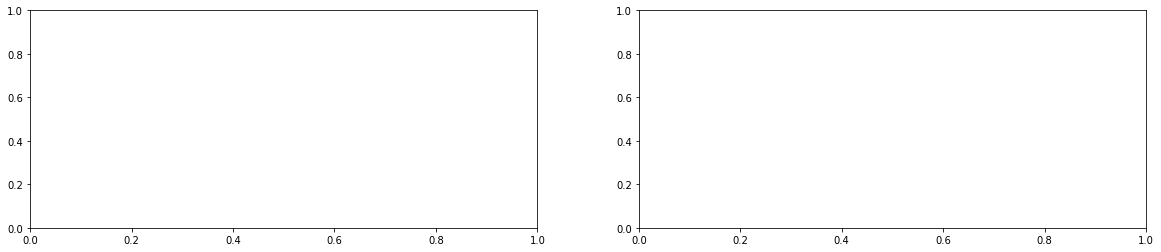

In [10]:
#Grouping the df by main category, sorted by sum of converted_pledged amount.
top_pledged = df.loc[:,df['state'] == 'succesful'].groupby(['category_parent_name']).sum().reset_index().sort_values(by='converted_pledged_amount', ascending=False)
top_backers = df.groupby(['category_parent_name']).sum().reset_index().sort_values(by='backers_count', ascending=False)
#Selecting top five from top_pledged and top_backers
top_five_pledged = top_pledged.head(5)
top_five_backers = top_backers.head(5)
pal_pled = sns.color_palette("Greens_d", len(top_five_pledged))
pal_back = sns.color_palette("Reds_d", len(top_five_backers))
rank_pled = top_five_pledged["converted_pledged_amount"].argsort().argsort()
rank_back = top_five_backers["backers_count"].argsort().argsort()
#Plotting the top five
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
sns.barplot(ax =axes[0], x='converted_pledged_amount',y='category_parent_name', data=top_five_pledged, linewidth=0.7, palette=np.array(pal_pled[::+1])[rank_pled])
axes[0].set_title('Converted Amount Pledged')
sns.barplot(ax=axes[1], x='backers_count',y='category_parent_name', data=top_five_backers, linewidth=0.7, palette=np.array(pal_back[::+1])[rank_back])
axes[1].set_title('Number of Backers');

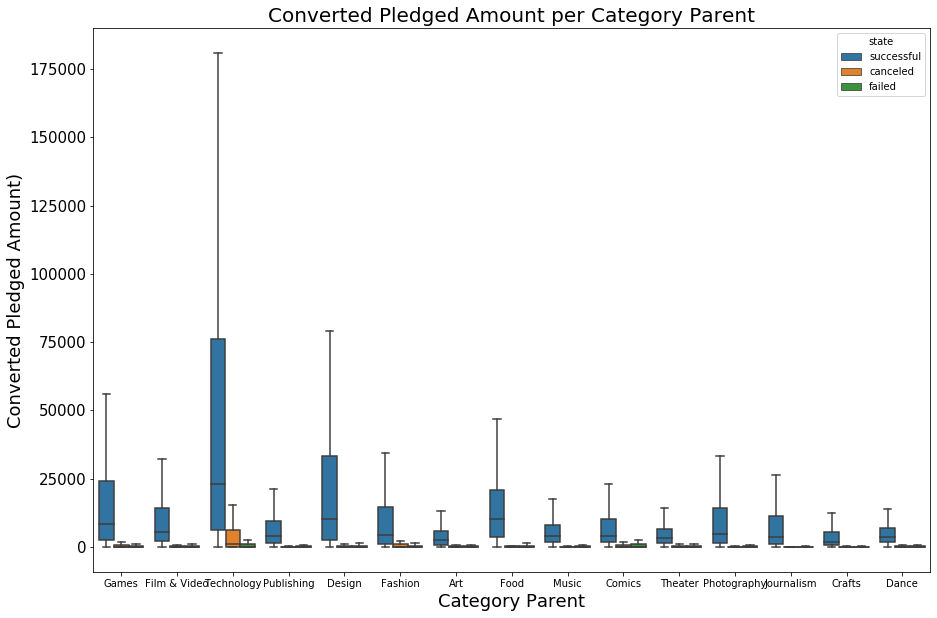

In [11]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='category_parent_name', y='converted_pledged_amount', hue='state', data=df, orient='v', showfliers=False);
plt.title('Converted Pledged Amount per Category Parent', fontsize=20);
plt.xlabel('Category Parent', fontsize=18)
plt.ylabel('Converted Pledged Amount)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=15);

#Can we use "proportion of the population" - om significant verschil tussen succesful (tech en de rest)


In [12]:
df.groupby(['category_name']).sum().sort_values(by='converted_pledged_amount', ascending=False)

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,spotlight,state_changed_at,usd_pledged,category_id,category_parent_id,project_id,average_pledge
category_name,,,,,,,,,,,,,,,,
Hardware,1286245,196945535,3459116835082,3482829545938,2321.508517,1.712735e+08,2496942224713,3475546889691,2.518419e+08,1493,3482829566508,1.969461e+08,122980,37840.0,5423758965,435614.171354
Product Design,1836490,195410063,3288888432554,3309783880291,1937.949813,5.246923e+07,2248122705553,3303751295987,4.803735e+08,2094,3309783894289,1.949631e+08,58632,14658.0,8011439673,308564.676186
Tabletop Games,2061370,159820464,3279620274948,3296165718794,2108.659101,3.034394e+07,2233736784496,3291858067796,2.148260e+08,2074,3296165773964,1.595537e+08,70516,24888.0,8132985556,107572.879384
Gadgets,1410605,149058918,3530994302559,3553119830674,2177.168811,2.737856e+08,2487122507367,3545770541605,2.699347e+08,1541,3553123123754,1.490372e+08,788580,37440.0,7137610299,290280.180302
Video Games,2559287,131884705,3403568403792,3426732407664,2241.904576,2.658325e+08,2455947403317,3420434257454,1.088081e+09,2278,3426732440955,1.318331e+08,79730,27336.0,6430744358,111495.776507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Embroidery,4750,257591,260464329246,261325729285,162.596988,1.900424e+06,190511879187,260857520894,1.404791e+06,43,261303707016,2.578988e+05,60550,4550.0,476602628,5833.368007
Farmer's Markets,2475,240260,36396170813,36533849276,22.204281,2.740580e+05,26893002362,36460045707,3.560157e+05,24,36533849350,2.402092e+05,7440,240.0,77651201,2943.938611
Quilts,2151,197610,135684563682,136271980583,92.308099,2.125914e+06,98326561182,136013398218,3.433291e+05,21,136265797579,1.981368e+05,33088,2444.0,187112001,4152.037384


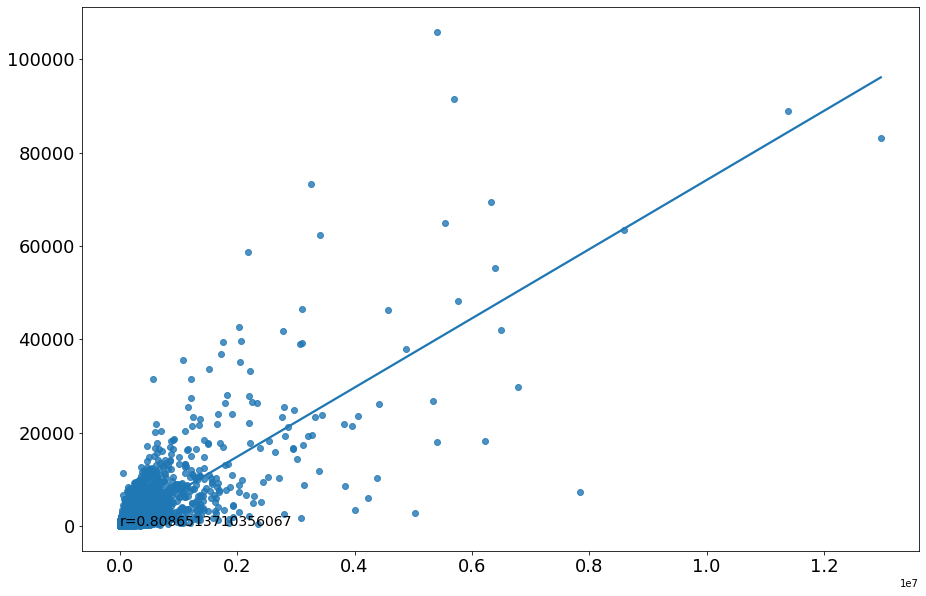

In [13]:
#corr
corr = df['converted_pledged_amount'].corr(df['backers_count'])
#set figure size
plt.figure(figsize=(15, 10))
#plot the data
sns.regplot(data=df,x=df['converted_pledged_amount'],y=df['backers_count'], ci=None)
#format the plot
text = 'r=%s' % (corr)
plt.text(1, 19, text, fontsize=14)
plt.title('', fontsize=20);
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

# Statistical Analysis

In [14]:
#Confidence Intervals:
# To define between pledge amount x and x we should ask
# To define between number of backers x and x we should aim for

# One-sample
# 1 category opposed to population mean

# Two-sample
#2 categories (tech vs. food) and Netherlands/Europe vs. US

**Categories** (Assumption that Technology startups have highest funding due to popularity/size of investments) 

https://producthype.co/kickstarter-tips-2019/ 

        - Succesful campaigns
        -> ratio succesful/unsuccesful/live definieren
        -> one-sample 1 tegenover het totaal
        -> two sample 1 tegenover de rest, of Tech vs Design 
        
*   H0: $\mu_{1} = \mu_{2}$, There is no difference between total pledge for successful campaigns in the Technology category and all other categories
*   H1: $\mu_{1} \neq \mu_{2},$ There is a difference between total pledge for successful campaigns in the Technology category and all other categories

For this test, we have to groups in which we can not match the rows to eachother, hence **independent samples**.
Secondly, we assume a **normally distributed population**.

(?) We cannot (or do not want to) assume Equal Variances.

/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


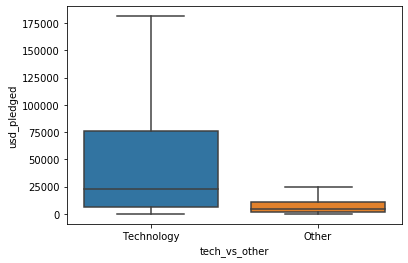

In [15]:
#Compute variables to test
succesful_campaigns = df.loc[df['state'] == 'successful']
succesful_campaigns_tech = succesful_campaigns.loc[succesful_campaigns['category_parent_name'] == 'Technology']
succesful_campaigns_other = succesful_campaigns.loc[succesful_campaigns['category_parent_name'] != 'Technology']

#Plot to estimate differences
succesful_campaigns['tech_vs_other'] = np.where(succesful_campaigns['category_parent_name']=='Technology', 'Technology', 'Other')
ax = sns.boxplot(x="tech_vs_other", y="usd_pledged", data=succesful_campaigns, order=["Technology", "Other"], showfliers=False)

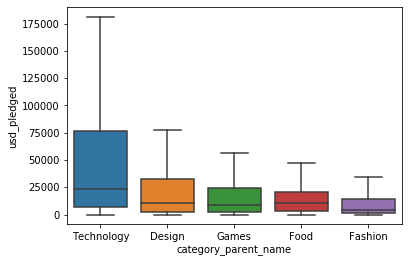

In [16]:
#Plot boxplots versus other five top categories according to count
ax = sns.boxplot(x="category_parent_name", y="usd_pledged", data=succesful_campaigns, order=["Technology", "Design", "Games", "Food", "Fashion"], showfliers=False)

In [17]:
from scipy.stats import ttest_ind

#Decide whether equal variances are true or false
ttest_ind(succesful_campaigns_tech['usd_pledged'], succesful_campaigns_other['usd_pledged'], equal_var=False)
ttest_ind(succesful_campaigns_tech['usd_pledged'], succesful_campaigns_other['usd_pledged'], equal_var=True)

Ttest_indResult(statistic=49.06560905309637, pvalue=0.0)

In [18]:
#Idea: build a loop two-sample-t-test for testing Technology against Design, Games, Food and Fashion.

- US vs NL (Assumption: Silicon Valley vs. the Netherlands)
    - Usd pledged in NL hoger OF lager dan in US (1 of 2 sample T test)  
    -> Dict "location" needs to be unfolded ('name', 'expanded_country')  
    -> Test binnen alle categorien eerst, eventueel later alleen in hierboven gekozen categorie  
Rianne

- Number of backers (Assumption: popularity of campaign defines popularity of startup)
    - Ga je voor weinig backers met veel of veel backers met weinig -> verschil in succesful  
        -> Define average pledge per backer (see to do)  
        -> Succesful versus unsuccesful (2-sample: avg. per backer succesful versus avg. per backer unsuccesful)  
            We verwachten dat dit verschilt - gemiddelde bij succesvol hoger
Rianne  
            
- Zoja/Zonee -> define confidence intervals voor backers voor ons "start-up" plan (binnen onze categorie?)  

Elske

In [19]:
# Sample represents the numbers of backers for succesful campaigns within the "Tech" category
succesful_campaigns = df.loc[df['state'] == 'successful']
succesful_campaigns_tech = succesful_campaigns.loc[succesful_campaigns['category_parent_name'] == 'Technology']
sample = succesful_campaigns_tech['backers_count']

#Compute degrees of freedom
df = len(sample) -1 

#Compute t-statistic, mean and standard error
t = stats.t.interval(0.95,df)[1]
x  = np.mean(sample)
se = np.std(sample) / np.sqrt(len(sample))

#Define confidence intervals
con_int = [round(num,3) for num in [x - (t * se) , x + (t * se)]]
print('With 95 % confidence, the average number of backers for a succesful campaign in Technology:', round(con_int[0]), "and", round(con_int[1]))

With 95 % confidence, the average number of backers for a succesful campaign in Technology: 647 and 747


Bonus:
In specific categories: Pledge amount asked - Pledged (goal - converted)  
COVID impact 2020 versus 2018/2019 (less pledges than previous years - and in which categories?)  
Other differences in years   
    